In [1]:
import xml.etree.ElementTree as ET
import os
import matplotlib.pyplot as plt


import cv2
import torch
from torchvision.ops import box_iou
import numpy as np

In [2]:
sample_number = 100 #139
DATA_PATH = '/dtu/datasets1/02516/potholes'

In [3]:

def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    size = root.findall('size')
    width = int(size[0].find('width').text)
    height = int(size[0].find('height').text)

    boxes = []
    for obj in root.findall('object'):
        # label = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)

        # Normalize coordinates
        xmin = xmin / width
        ymin = ymin / height
        xmax = xmax / width
        ymax = ymax / height

        boxes.append((xmin, ymin, xmax, ymax))
    
    boxes = torch.tensor(boxes, dtype=torch.float32)
    return boxes


tensor(164.4800) tensor(46.0800) tensor(241.9200) tensor(107.5200)


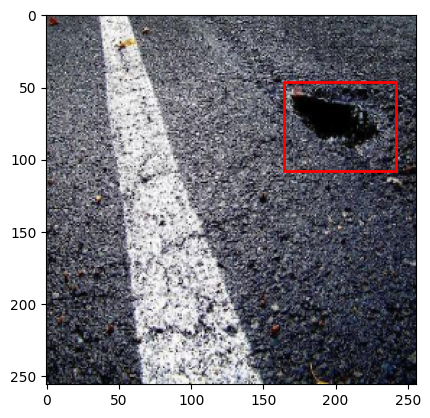

In [4]:
# Load and display image
img_path = os.path.join(DATA_PATH, 'images', f'potholes{sample_number}.png')
img = plt.imread(img_path)

# Resize image for Selective Search
img_width = 256
img_height = 256
img = cv2.resize(img, (img_width, img_height))
plt.imshow(img)

xml_file_path = os.path.join(DATA_PATH, 'annotations', f'potholes{sample_number}.xml')
boxes = parse_annotation(xml_file_path)
# Plot bounding boxes on the image (optional)
for xmin, ymin, xmax, ymax in boxes:
    xmin = xmin * img_width
    ymin = ymin * img_height
    xmax = xmax * img_width
    ymax = ymax * img_height
    plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                      fill=False, edgecolor='red', linewidth=2))
    
    print(xmin, ymin, xmax, ymax)

In [5]:

# Initialize Selective Search
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(img)
ss.switchToSelectiveSearchFast()  # or switchToSelectiveSearchQuality() for better proposals


In [6]:

# Run Selective Search
rects = ss.process()  # returns list of [x, y, w, h]


In [7]:
ss_boxes = []
for (x, y, w, h) in rects:
    xmin = x / img_width
    ymin = y / img_height
    xmax = (x + w) / img_width
    ymax = (y + h) / img_height
    ss_boxes.append((xmin, ymin, xmax, ymax))  # Convert to (xmin, ymin, xmax, ymax) format

ss_boxes = torch.tensor(ss_boxes, dtype=torch.float32)

In [8]:
ss_boxes.shape

torch.Size([471, 4])

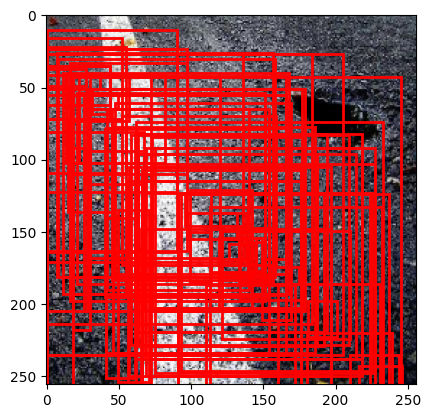

In [ ]:

plt.imshow(img)
for i in range(100):
    xmin, ymin, xmax, ymax = ss_boxes[i]
    xmin = xmin * img_width
    ymin = ymin * img_height
    xmax = xmax * img_width
    ymax = ymax * img_height
    plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                      fill=False, edgecolor='red', linewidth=2))

In [10]:
def evaluate_proposals(gt_boxes, proposal_boxes, iou_threshold=0.5, max_proposals=[100, 500, 1000]):
       

    results = {}
    for max_prop in max_proposals:
        covered = 0
        total = 0
        
        
        for gt_box, proposal_box in zip(gt_boxes, proposal_boxes): # loop over images
            proposals = proposal_box[:max_prop]
            # proposals = torch.tensor(proposals, dtype=torch.float32).unsqueeze(0)
            gt_box = torch.tensor(gt_box, dtype=torch.float32)
            # print("GT BOX:", gt_box)
            # print("PROPOSALS:", proposals)
            ious = box_iou(gt_box, proposals)  # Exclude labels for IoU calculation

            matches = ious >= iou_threshold
            
            covered += (ious.max(dim=1)[0] >= iou_threshold).sum().item()
            total += gt_box.shape[0]
            print(ious.max(dim=1)[0])

        recall  = covered / total
        results[max_prop] = recall
    
    return results

In [11]:
boxes[0]

tensor([0.6425, 0.1800, 0.9450, 0.4200])

In [12]:
a = evaluate_proposals([boxes], [ss_boxes])

tensor([0.4036])
tensor([0.6567])
tensor([0.6567])


/tmp/ipykernel_4154476/3502837728.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gt_box = torch.tensor(gt_box, dtype=torch.float32)


In [13]:
a

{100: 0.0, 500: 1.0, 1000: 1.0}

Text(0, 0.5, 'Recall')

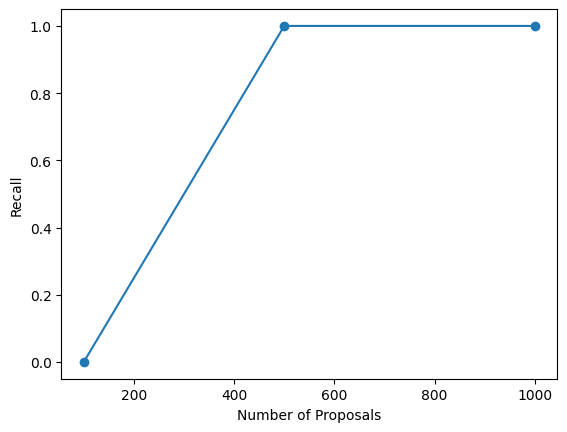

In [14]:
# Plot recall vs number of proposals
plt.figure()
plt.plot(list(a.keys()), list(a.values()), marker='o')
plt.xlabel('Number of Proposals')
plt.ylabel('Recall')